# Final Project Submission

Please fill out:
* Student name: Callum Ballard
* Student pace: Part Time
* Scheduled project review date/time: Monday June 24th 2019
* Instructor name: Jeff Herman
* Blog post URL: https://medium.com/@callumballard/worthless-in-seattle-9300b3594383


# 1) Initial set up
### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
%matplotlib inline

In [2]:
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

Set graphing style, with custom colour pallette.

In [3]:
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

CB91_LBlue = '#D5F2FF'
CB91_LGreen = '#DAF8F5'
CB91_LPink = '#FDECFC'
CB91_LPurple = '#9D2EC5'
CB91_LViolet = '#ECD4F5'
CB91_LAmber = '#E2C8F4'

CB91_DBlue = '#016794'
CB91_DGreen = '#187970'
CB91_DPink = '#B317B1'
CB91_DPurple = '#4E1762'
CB91_DViolet = '#330E4C'
CB91_DAmber = '#985E09'

In [4]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[CB91_Blue,
                                                    CB91_Green,
                                                    CB91_Pink,
                                                    CB91_Purple,
                                                    CB91_Violet,
                                                    CB91_Amber])

### Import data

In [5]:
df = pd.read_csv('kc_house_data.csv')

In [6]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Note - column headings can be inferred from King County website glossary, found here: https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

We can drop the ID column, since this refers to the ID of sale transaction of the property, and gives no further information.

In [7]:
df.drop('id', axis = 1, inplace = True)

In [8]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# 2) Inspect, wrangle, and clean the data

### Check for duplicate data

In [9]:
len(df[df.duplicated()])

0

Thus, we have no duplicate data.

### Check for data types, and missing data (NaNs)
First investigate the data types, and recast as appropriate. Then find where data is missing, and investigate if we can use a substitute value (or if we should simply drop rows / columns).

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(10), object(2)
memory usage: 3.3+ MB


We can see that some of the data is not in the format that we would expect. In particular:
* Date needs converting to datetime
* sqft_basement needs to be int64, as per the format of sqft_above

In [11]:
df['date'] = pd.to_datetime(df['date'])

If we investigate the basement data, we can see that it was of 'object' type due to the '?' entries. For these rows, we can investigate the existing relationship between sqft_living, and sqft_above, to see if we can imply a value for basement area. Otherwise, we can delete the rows.

In [12]:
df.groupby(by = 'sqft_basement')['sqft_basement'].count().sort_values(ascending = False).head(4)

sqft_basement
0.0      12826
?          454
600.0      217
500.0      209
Name: sqft_basement, dtype: int64

In [13]:
len(df.loc[(df['sqft_basement'] == '?') & (df['sqft_living'] != df['sqft_above'])
       ,['sqft_living','sqft_above']])

170

We can see that there are 170 instances of us being able to infer a basement value from the 'sqft_living' and 'sqft_above' values. We can create this calculation and update the dataframe. Otherwise, we can assume that there is no basement, and update with 0.

In [14]:
for i in list(df.loc[df['sqft_basement'] == '?'].index.values):
    df.loc[i,'sqft_basement'] = df.loc[i,'sqft_living'] - df.loc[i,'sqft_above']

Having dealt with the question marks, we can now cast this column type as a float.

In [15]:
df['sqft_basement'] = df['sqft_basement'].astype('float64')

However, given the number of houses without basements (as per the below histogram), we could simply break this down into a new binary category - houses with basements, and those without.

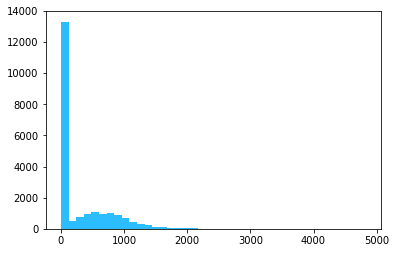

In [16]:
plt.hist(df['sqft_basement'],bins = 40);

In [17]:
df['basement'] = df['sqft_basement'].map(lambda x: 0 if x == 0 else 1)
df.drop('sqft_basement', axis = 1, inplace = True)

### Tackle NaN values
Regarding data completeness, we have full data apart from in the Waterfront and Year Renovated columns.

In [18]:
len(df.loc[(df['yr_renovated'].isna()) | (df['waterfront'].isna())]) / len(df)

0.2680001852109089

This affects 5,788 entries, or 27% of the data. We can investigate these columns further.

In [19]:
df.groupby(by = 'yr_renovated')['yr_renovated'].count().sort_values(ascending = False).head()

yr_renovated
0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
Name: yr_renovated, dtype: int64

We can see that the majority of numerical values in the 'yr_renovated' column are '0', implying that data here is unknown. We can thus drop the column.

In [20]:
df.drop('yr_renovated', axis = 1, inplace = True)

In [21]:
len(df.loc[(df['waterfront'].isna())]) / len(df)

0.11001527989998611

We now see that only 11% of rows have NaNs (all in the waterfront column). This is a small enough part of the sample for us to simply drop the offending rows.

In [22]:
df.dropna(inplace=True)

### Check for other implausible numerical data used in place of unknowns
Go through the most common entries by column, and see if there are any suspicious values entered many times, which could be indicative of placeholder data.

In [23]:
for i in df.columns:
    print(df.groupby(by = i)[i].count().sort_values(ascending = False).head())
    print("\n")

date
2014-06-23    124
2014-06-25    120
2014-06-26    116
2014-07-08    114
2015-04-21    111
Name: date, dtype: int64


price
450000.0    152
350000.0    146
550000.0    144
500000.0    142
425000.0    135
Name: price, dtype: int64


bedrooms
3    8691
4    6133
2    2446
5    1437
6     225
Name: bedrooms, dtype: int64


bathrooms
2.50    4828
1.00    3402
1.75    2713
2.25    1779
2.00    1718
Name: bathrooms, dtype: int64


sqft_living
1300    125
1440    121
1400    119
1820    118
1660    113
Name: sqft_living, dtype: int64


sqft_lot
5000    328
6000    253
4000    222
7200    186
4800    112
Name: sqft_lot, dtype: int64


floors
1.0    9464
2.0    7329
1.5    1675
3.0     546
2.5     144
Name: floors, dtype: int64


waterfront
0.0    19019
1.0      145
Name: waterfront, dtype: int64


view
0.0    17312
2.0      836
3.0      435
1.0      291
4.0      290
Name: view, dtype: int64


condition
3    12437
4     5041
5     1509
2      152
1       25
Name: condition, dtype: int64


g

#### Observations from the above:
* We see that the values for bathrooms are not just integers - we have 0.25 of a bathroom in many instances - presumably this is how 'en suites' are being represented.
* 'View' is a variable given on a 0-4 scale, where the vast majoirty of properties are 0. It is possible that 'view' refers to the number of times a propery was viewed during the sales process. In which case, it is likely that the 0s are placeholders. Given the number of 0 entries, it may be worthwhile to drop this column.

Otherwise, there are no obvious instances of placeholder values.

In [24]:
df.drop('view', axis = 1, inplace = True)

### Checking for outliers
If our goal is to build a model for the 'average' house, then having very significant outliers will be unhelpful for the final model. We can check if there are significant outliers on a feature by feature basis, by creating histograms of each feature, and also observing the highest and lowest values feature by feature, counting the frequency of each.

/Users/Callum/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


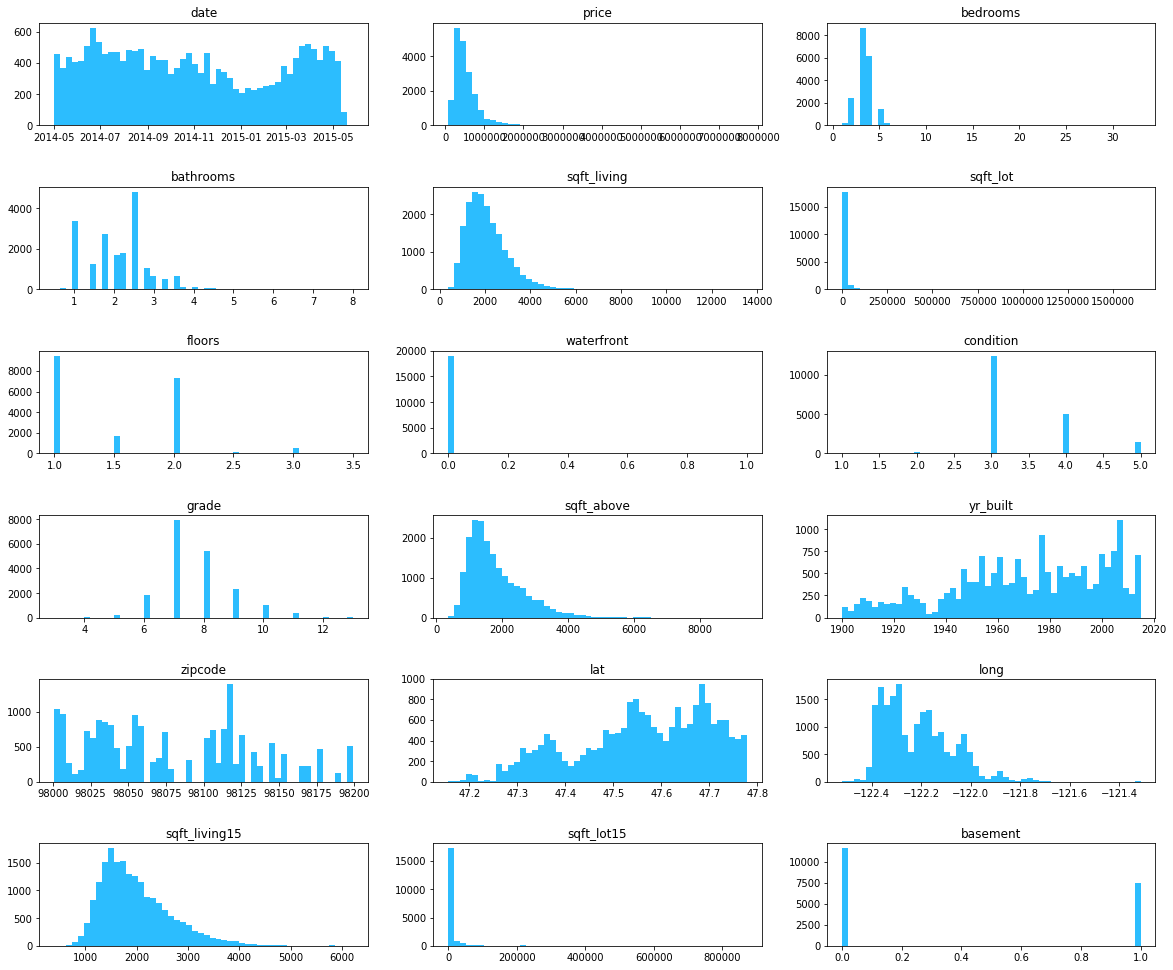

In [25]:
c = []   #the list of columns we'll turn into histograms
n = 3    #the number of histogram subplots we'll want in each row

for i in df.columns:
    if df[i].dtype != 'object':
        c.append(i)
        
l = len(c)

fig, axes = plt.subplots(ncols = n, nrows = l // n + 1, figsize = (20,20))

fig.subplots_adjust(hspace=0.6)

for a in range(l):
    ax = axes[a//n][a%n]
    ax.hist(df[c[a]], bins = 50)
    ax.set_title(c[a])

spare = n * (l // n + 1) - l    #working out how many empty axes we'll end up

for b in range(spare):          #deleting all spare axes
    fig.delaxes(axes[l // n][n - 1 - b])

In [26]:
for i in df.columns:
    print(i.upper())
    print(df[i].value_counts().sort_index(ascending = False).head(5))
    print("--------")
    print(df[i].value_counts().sort_index(ascending = False).tail(5))
    print("\n")

DATE
2015-05-27     1
2015-05-24     1
2015-05-15     1
2015-05-14     9
2015-05-13    28
Name: date, dtype: int64
--------
2014-05-06    77
2014-05-05    75
2014-05-04     4
2014-05-03     4
2014-05-02    60
Name: date, dtype: int64


PRICE
7700000.0    1
7060000.0    1
6890000.0    1
5570000.0    1
5350000.0    1
Name: price, dtype: int64
--------
84000.0    1
83000.0    1
82500.0    1
82000.0    1
78000.0    1
Name: price, dtype: int64


BEDROOMS
33     1
11     1
10     3
9      6
8     11
Name: bedrooms, dtype: int64
--------
5    1437
4    6133
3    8691
2    2446
1     175
Name: bedrooms, dtype: int64


BATHROOMS
8.00    2
7.75    1
7.50    1
6.75    2
6.50    1
Name: bathrooms, dtype: int64
--------
1.50    1279
1.25       8
1.00    3402
0.75      65
0.50       4
Name: bathrooms, dtype: int64


SQFT_LIVING
13540    1
12050    1
10040    1
9890     1
9640     1
Name: sqft_living, dtype: int64
--------
420    2
410    1
390    1
380    1
370    1
Name: sqft_living, dtype: int64



We could conclude that a house with more than 7 bedrooms, more than 5 bathrooms, or with a lot of over 300k square feet, is unlikely to be representitive of the sample. Similarly, properties selling for over 1m USD (and indeed 100k USD) are liable to skew the model, as per the histogram above.

Looking at the lower end of the market - we can see only 21 houses with grades 3 or 4 (cabins or houses that do not meet building standards). These are unlikely to be representitive. We can also run with an assumption that a property probably ought to have at least 1 bathroom.

We can delete these houses from the dataset.

In [27]:
to_drop = df.loc[(df['bedrooms'] > 7) | (df['bathrooms'] > 5) | (df['bathrooms'] < 1) |
                 (df['sqft_lot'] > 300000) | (df['price'] > 1000000) | (df['price'] < 100000) | 
                 (df['grade'] < 5)].index
df.drop(to_drop, inplace = True)

We can also see that there are some properties that have a very high price per sq ft, suggesting that they are not representitive of the sample (they may have characteristics that are not reflected by the rest of the dataset, such as being penthouse flats, or being especially close to certain amenities).

In [28]:
df['price_per_sqft'] = df['price'] / df['sqft_living']

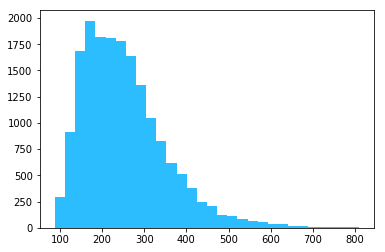

In [29]:
plt.hist(df['price_per_sqft'], bins = 30);

We can delete any properties that are over 600 dollars per sq ft.

In [30]:
to_drop = df.loc[(df['price_per_sqft'] > 600)].index
df.drop(to_drop, inplace = True)

In [31]:
df.drop('price_per_sqft', inplace = True, axis = 1)

### Deal with categorical variables
We can identify all categorical variables be creating scatters of each column against the dependent variable.

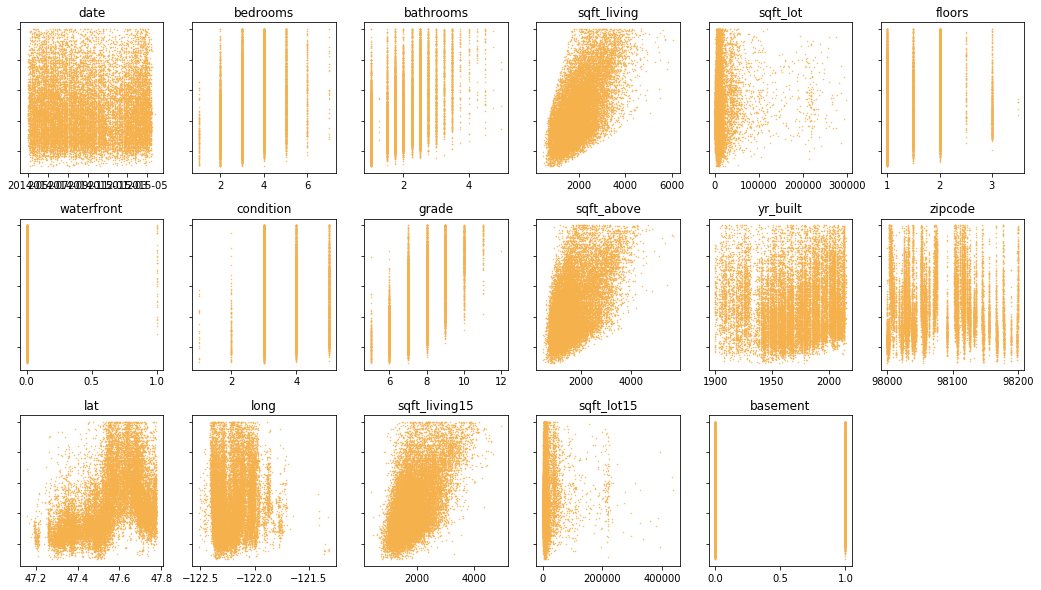

In [32]:
c = []
n = 6

for i in df.columns:
    if df[i].dtype != 'object':
        c.append(i)

c.remove('price')
l = len(c)

fig, axes = plt.subplots(ncols = n, nrows = l // n + 1, figsize = (18,10))

fig.subplots_adjust(hspace=0.3)

for a in range(l):
    ax = axes[a//n][a%n]
    ax.scatter(df[c[a]], df['price'], s=0.2, color=CB91_Amber);
    ax.set_yticklabels([])
    ax.set_title(c[a])

spare = n * (l // n + 1) - l

for b in range(spare):
    fig.delaxes(axes[l // n][n - 1 - b])

Evidently, our categorical variables are:
* Bedrooms
* Bathrooms
* Floors
* Waterfront
* Year built
* Condition
* Grade
* Zipcode
* Basement

However, many of these are ordinal. In particular, floors, bedrooms, bathrooms, and grade. We could thus leave these features as they are.

> _Note - Zipcode is also categorical, however it is not ordinal - a conscecutive postcode is neither necesserily better nor worse than the one before it. We shall come back to this later, with a full investigation into geography, using latitude and longitude._

We can now create categories for years, waterfront, condition, and basement.

In [33]:
bins_year = pd.cut(df['yr_built'], [1899, 1920, 1940, 1960, 1980, 2000, 2020])
bins_year = bins_year.cat.as_unordered()

year_dummies = pd.get_dummies(bins_year, prefix="year")
water_dummies = pd.get_dummies(df["waterfront"], prefix="water")
con_dummies = pd.get_dummies(df["condition"], prefix="con")
base_dummies = pd.get_dummies(df["basement"], prefix="base")

df.drop(["yr_built","waterfront","condition","basement"], axis=1, inplace = True)
df = pd.concat([df, year_dummies, water_dummies, con_dummies, base_dummies], axis=1)

We can automatically drop instances where we have only two categories - i.e. basement and waterfront, which are binary.

In [34]:
df.drop(["water_0.0","base_0"], axis=1, inplace = True)

## EDA Question 1
### Investigating the effect of dates
The below histogram suggests that the number of houses sold at different points in the year varies significantly, with only half as many houses being sold in January and February 2015 as at the peak around the start of May 2015. It may be worth a further investigation into whether this has an effect on price.

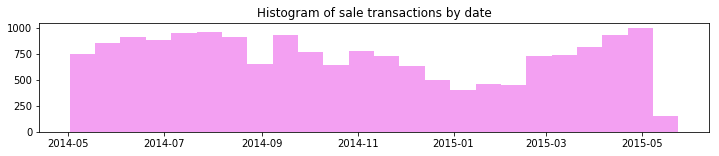

In [35]:
plt.figure(figsize = (12,2))
plt.hist(df['date'], color = CB91_Pink, bins = 24);
plt.title('Histogram of sale transactions by date');

In [36]:
df['sale_day'] = df['date'].map(lambda x: x.dayofweek)
df['sale_month'] = df['date'].map(lambda x: x.month)
df['quarter'] = df['date'].map(lambda x: x.quarter)

Here, we investigate the average sale price of houses at different times of the week / year.

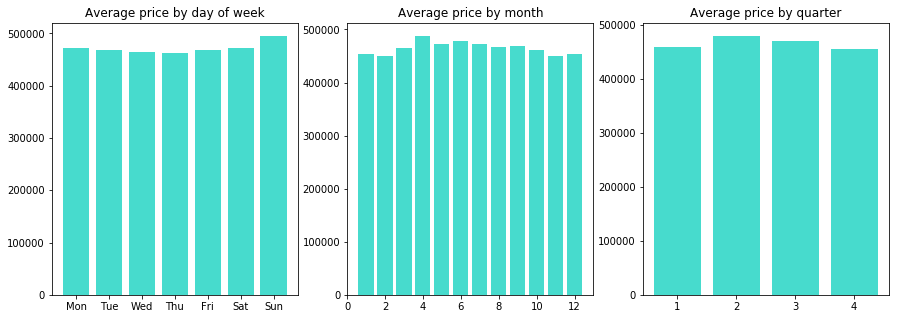

In [37]:
new_fig = plt.figure(figsize = (15,5))

ax = new_fig.add_subplot(131)
ax.bar(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], df.groupby('sale_day').mean()['price'], color = CB91_Green);

plt.title('Average price by day of week')

ax2 = new_fig.add_subplot(132)
ax2.bar(df.groupby('sale_month').mean()['price'].index.values, df.groupby('sale_month').mean()['price'], color = CB91_Green);

plt.title('Average price by month')

ax3 = new_fig.add_subplot(133)
ax3.bar(df.groupby('quarter').mean()['price'].index.values, df.groupby('quarter').mean()['price'], color = CB91_Green);

plt.title('Average price by quarter');

From this, we could conclude that there is some fluctuation in house price depending on the time of the year - with Q2 homes being slightly more valuable on average (the boxplot suggests that this is because there are fewer cheaper properties sold during Q2).

Of course, this could just be because bigger houses are sold at this time of year (or some other such independent variable).

We can include quarters in our dataset as categories to investigate this as part of the model.

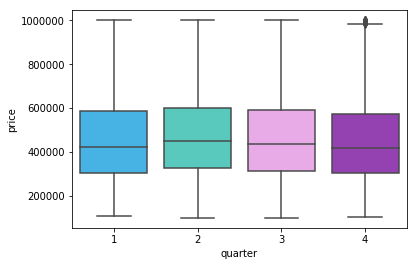

In [38]:
sns.boxplot(x = df['quarter'], y = df['price'], data=df);

In [39]:
quarter_dummies = pd.get_dummies(df["quarter"], prefix="q")
df.drop(["date","sale_day","sale_month","quarter"], axis=1, inplace = True)
df = pd.concat([df, quarter_dummies], axis=1)

## EDA Question 2:
### How is a property's price driven by its location?
So far, we have ignored the zipcode as a measure of price - there are too many categories, and they are not ordinal. Are we able to say anything about how latitude and logitude might effect price?

By plotting these on a scatter, colouring the points by price, we can get a sense of how area might drive the value of a property.

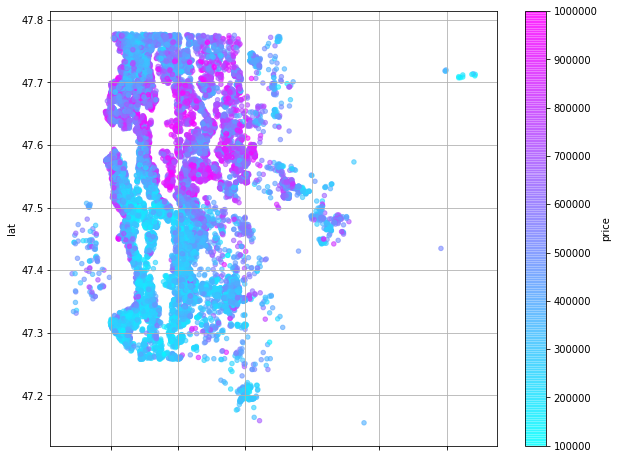

In [40]:
ax = df.plot.scatter('long','lat',c = 'price',cmap = 'cool', alpha = 0.6, figsize = (10,8), grid = True);

Firstly, we note some geographical outliers in the North East of the 'map' which may be worth removing from the data.

In [41]:
far_east = df.loc[df['long'] > (-120 - 1.69)]
df.drop(far_east.index, inplace = True)

As for the effect of geography on price, we can see that there appears to be some kind a north/south divide, however this is not universal (the very North of the map is mostly blue, lower value properties, having been mostly purple slightly further South). Thus, we can not assume a linear relationship between price, and either of longitude or latitude.

However, it is clear that expensive properties are clustered. It may therefore be worth demarkating 'areas' within the dataset, based on the zipcode data. These can then be used as categories in a multivariate linear regression. Zipcode data is categoried (A-I) as per the zipcode map on the King County website: https://www.kingcounty.gov/services/gis/Maps/vmc/Boundaries.aspx

* A - Seattle, Shoreline, Lake Forest Park
* B - Kirkland, Kenmore, Bothell, Redmond, Woodinville
* C - Bellevue, Mercer Island, Newcastle
* D - Renton, Kent
* E - Burien, Normandy Park, Des Moines, SeaTac, Tukwilla, Vashon Island
* F - Federal Way, Auburn, Algona, Milton, Pacific
* G - Sammamish, Issaquah, Carnation, Duvall
* H - Covington, Maple Valley, Black Diamond, Enumclaw
* I - Snoquaimie, North Bend

In [42]:
# Seattle, Shoreline, Lake Forest Park
Azips = [98177, 98133, 98125, 98155, 98107, 98115, 98105, 98109, 98112,
        98117, 98199, 98122, 98144, 98118, 98108, 98106, 98136, 98126,
        98116, 98102, 98103, 98119, 98134]

# Kirkland, Kenmore, Bothell, Redmond, Woodinville
Bzips = [98053, 98052, 98077, 98072, 98033, 98034, 98011, 98028]

# Bellevue, Medina, Mercer Island, Newcastle
Czips = [98059, 98056, 98006, 98040, 98008, 98007, 98005, 98004, 98039]

# Renton, Kent
Dzips = [98057, 98055, 98058, 98032, 98031, 98030, 98178]

# Burien, Normandy Park, Des Moines, SeaTac, Tukwilla, Vashon Island
Ezips = [98070, 98146, 98168, 98166, 98198, 98148, 98158, 98188]

# Federal Way, Auburn, Algona, Milton, Pacific
Fzips = [98023, 98003, 98063, 98047, 98001, 98002, 98093, 98071, 98002, 98092]

# Sammamish, Issaquah, Carnation, Duvall
Gzips = [98074, 98075, 98029, 98027, 98019, 98014]

# Covington, Maple Valley, Black Diamond, Enumclaw
Hzips = [98022, 98042, 98010, 98038, 98051]

# Snoquaimie, North Bend
Izips = [98065, 98045, 98024]

We then create a function 'zipcode', which takes a zipcode and tells you which of these 'areas' it falls in (returning 'X' if the zipcode falls out of the pre-defined areas).

In [43]:
def zipcode(x):
    
    '''Parameters:
           x (int): The property's zip code.
       Returns:
           zipcode group (str): The property's area group (a letter from A to I)
           Will return X if zip code not recognised.'''
    
    if x in Azips:
        return 'A'
    elif x in Bzips:
        return 'B'
    elif x in Czips:
        return 'C'
    elif x in Dzips:
        return 'D'
    elif x in Ezips:
        return 'E'
    elif x in Fzips:
        return 'F'
    elif x in Gzips:
        return 'G'
    elif x in Hzips:
        return 'H'
    elif x in Izips:
        return 'I'
    else:
        return 'X'

Having made our categories, we can drop zipcode, latitude, and longitude columns in our dataframe, and add in our new 'area' categories to the dataset.

In [44]:
df['zipcat'] = df['zipcode'].map(zipcode)
zip_dummies = pd.get_dummies(df["zipcat"], prefix="zip")
df.drop(["zipcat","zipcode","lat","long"], axis=1, inplace = True)
df = pd.concat([df, zip_dummies], axis=1)

## EDA Question 3:
### What of the 15 nearest neighbours?

The dataset includes two columns, 'sqft_living15' and 'sqft_lot15'. We take it that this refers to the average areas of the property's 15 nearest neighbours.

We have already seen that we have complete data for these columns. However, they could be awkward in a final model - if we're evaluating the price of a house on the market, then we would have access to the attributes of that property. However, it is not a given that we'd know anything about the neighbouring properties with any degree of accuracy.

Thus, we should investigate further, and see if the columns would be worth keeping.

### Relationship between size of property, and the size of its neighbours.

How well does the size of neighbouring property predict the size of a house?

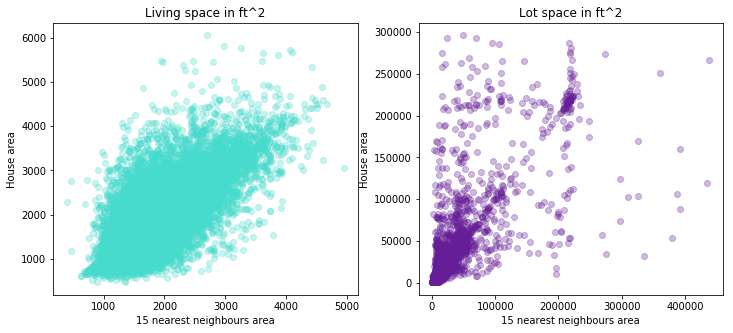

In [45]:
fig = plt.figure(figsize = (12,5))

ax1 = fig.add_subplot(121)
ax1.scatter(df['sqft_living15'], df['sqft_living'],  color = CB91_Green, alpha = 0.3);
ax1.set_title('Living space in ft^2');
ax1.set_xlabel('15 nearest neighbours area');
ax1.set_ylabel('House area');

ax1 = fig.add_subplot(122)
ax1.scatter(df['sqft_lot15'], df['sqft_lot'],  color = CB91_Violet, alpha = 0.3);
ax1.set_title('Lot space in ft^2');
ax1.set_xlabel('15 nearest neighbours area');
ax1.set_ylabel('House area');

So whilst there is a very slight correlation in living space, we can certainly discount a relationship between lot space of neighbouring properties.

Running a linear regression of the living space metrics suggests an R-squared of 0.54 - not insignificant, but not high enough to suggest a strong relationship either.

In [46]:
model = ols(formula='sqft_living15~sqft_living', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          sqft_living15   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                 2.072e+04
Date:                Sun, 23 Jun 2019   Prob (F-statistic):               0.00
Time:                        18:26:04   Log-Likelihood:            -1.3022e+05
No. Observations:               17540   AIC:                         2.604e+05
Df Residuals:                   17538   BIC:                         2.605e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     749.2837      8.642     86.703      0.000     732.344     766.223
sqft_living     0.5921      0.004    143.956      0.000       0.584       0.600
==============================================================================
Omnibus:                      643.973   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1893.174
Skew:                           0.072   Prob(JB):                         0.00
Kurtosis:                       4.603   Cond. No.                     5.93e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

It's not obvious that the 15 nearest neighbour features are going to add anything insightful enough to justify their inclusion in the final model. We can drop them from the dataframe.

In [47]:
df.drop(["sqft_lot15","sqft_living15"], axis=1, inplace = True)

### Consider if there are any sensible single-variable linear regression models
Before we continue with the multi-variate regression, we can go through the continuous dependent variables in turn, and investigate their appropriateness for single variable linear regression.

King County House sales dataset - Regression Analysis / Diagnostics for formula: price~bedrooms
-------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     1723.
Date:                Sun, 23 Jun 2019   Prob (F-statistic):               0.00
Time:                        18:26:04   Log-Likelihood:            -2.3772e+05
No. Observations:               17540   AIC:                         4.754e+05
Df Residuals:                   17538   BIC:                         4.755e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std

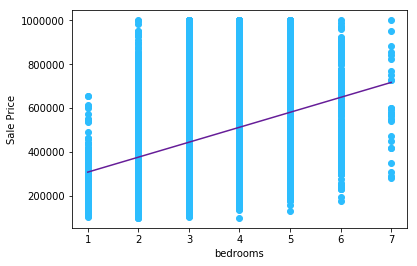

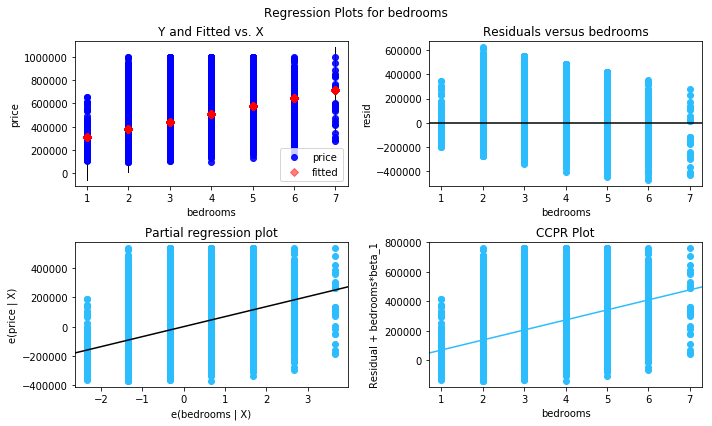

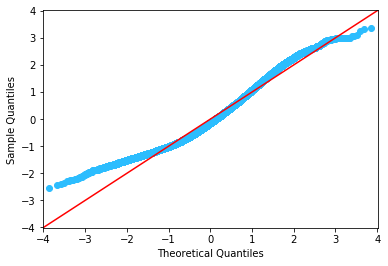

King County House sales dataset - Regression Analysis / Diagnostics for formula: price~bathrooms
-------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     4359.
Date:                Sun, 23 Jun 2019   Prob (F-statistic):               0.00
Time:                        18:26:07   Log-Likelihood:            -2.3660e+05
No. Observations:               17540   AIC:                         4.732e+05
Df Residuals:                   17538   BIC:                         4.732e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    st

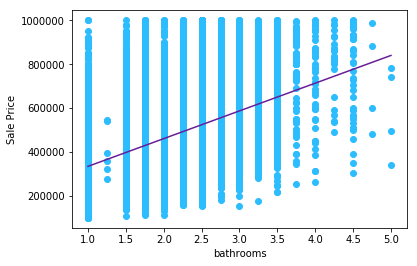

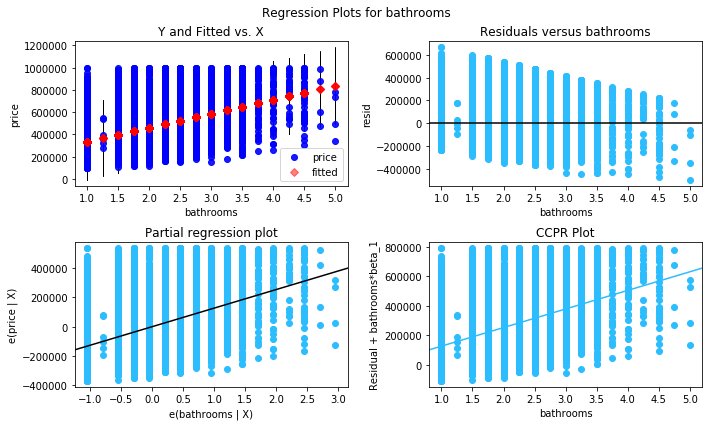

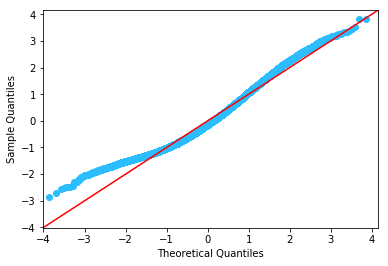

King County House sales dataset - Regression Analysis / Diagnostics for formula: price~sqft_living
-------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                 1.072e+04
Date:                Sun, 23 Jun 2019   Prob (F-statistic):               0.00
Time:                        18:26:10   Log-Likelihood:            -2.3436e+05
No. Observations:               17540   AIC:                         4.687e+05
Df Residuals:                   17538   BIC:                         4.687e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef   

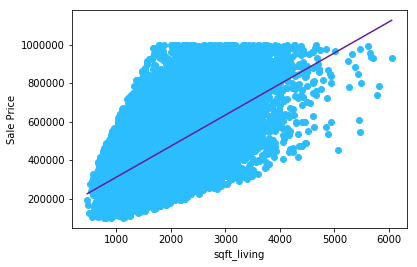

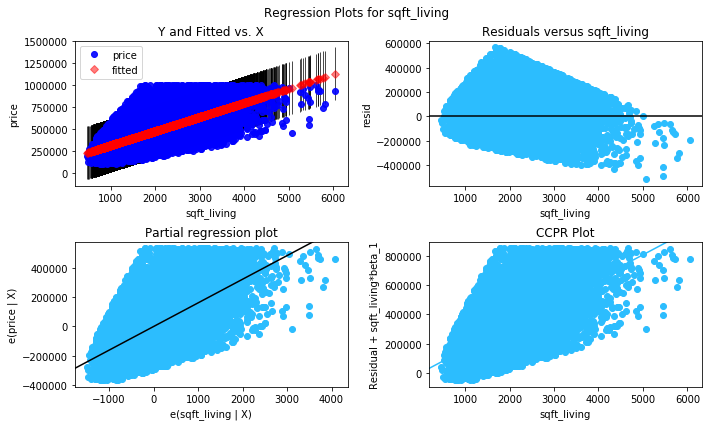

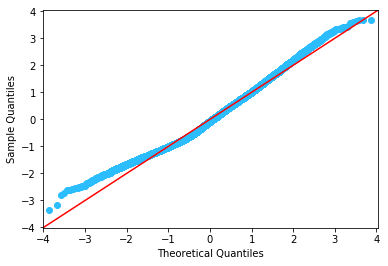

King County House sales dataset - Regression Analysis / Diagnostics for formula: price~sqft_lot
-------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     175.7
Date:                Sun, 23 Jun 2019   Prob (F-statistic):           6.63e-40
Time:                        18:26:14   Log-Likelihood:            -2.3845e+05
No. Observations:               17540   AIC:                         4.769e+05
Df Residuals:                   17538   BIC:                         4.769e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std

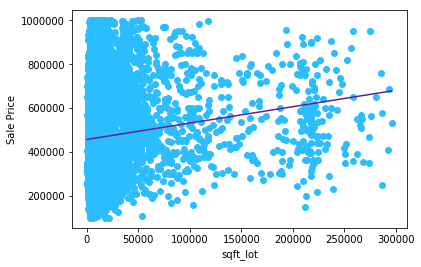

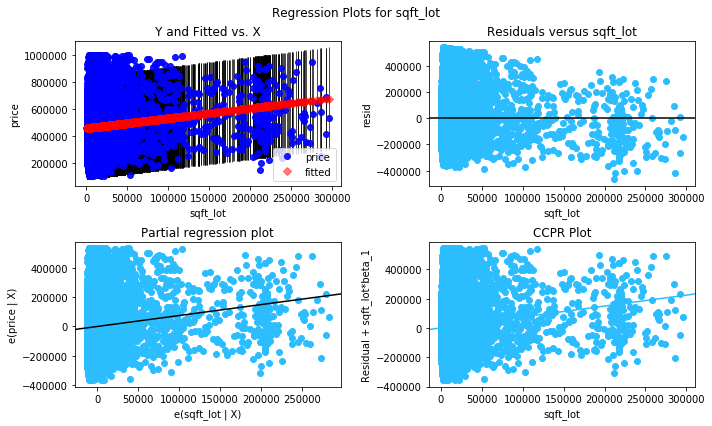

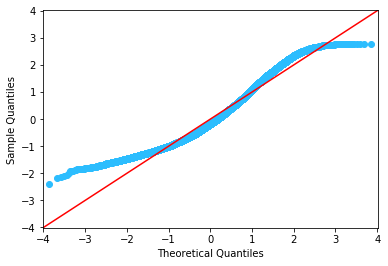

King County House sales dataset - Regression Analysis / Diagnostics for formula: price~floors
-------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     1448.
Date:                Sun, 23 Jun 2019   Prob (F-statistic):          1.65e-304
Time:                        18:26:17   Log-Likelihood:            -2.3785e+05
No. Observations:               17540   AIC:                         4.757e+05
Df Residuals:                   17538   BIC:                         4.757e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std e

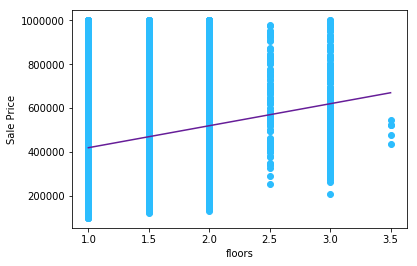

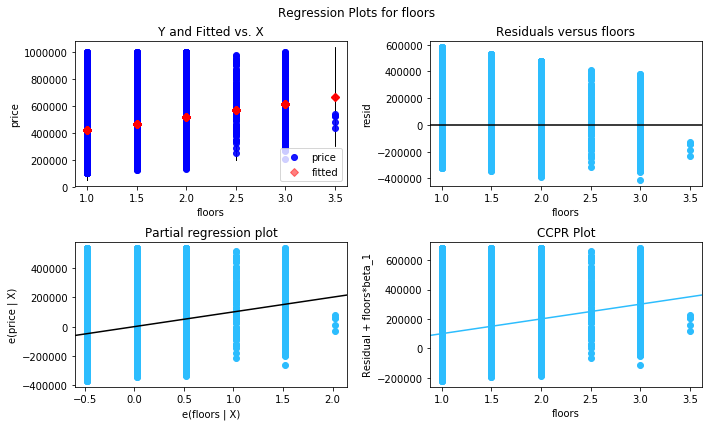

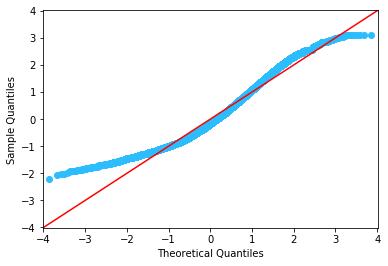

King County House sales dataset - Regression Analysis / Diagnostics for formula: price~grade
-------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                 1.129e+04
Date:                Sun, 23 Jun 2019   Prob (F-statistic):               0.00
Time:                        18:26:20   Log-Likelihood:            -2.3418e+05
No. Observations:               17540   AIC:                         4.684e+05
Df Residuals:                   17538   BIC:                         4.684e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std er

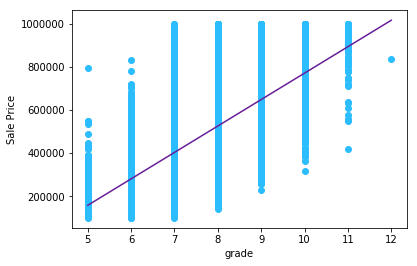

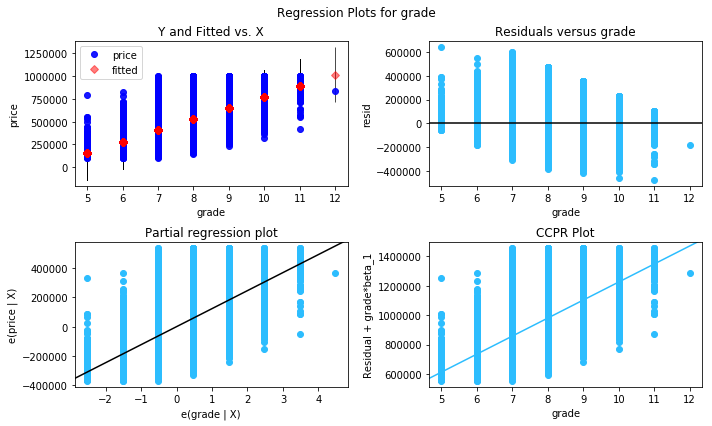

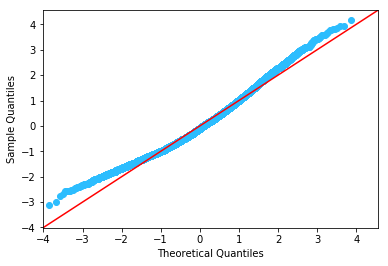

King County House sales dataset - Regression Analysis / Diagnostics for formula: price~sqft_above
-------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     6670.
Date:                Sun, 23 Jun 2019   Prob (F-statistic):               0.00
Time:                        18:26:23   Log-Likelihood:            -2.3572e+05
No. Observations:               17540   AIC:                         4.714e+05
Df Residuals:                   17538   BIC:                         4.715e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    s

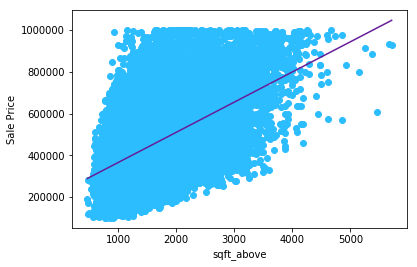

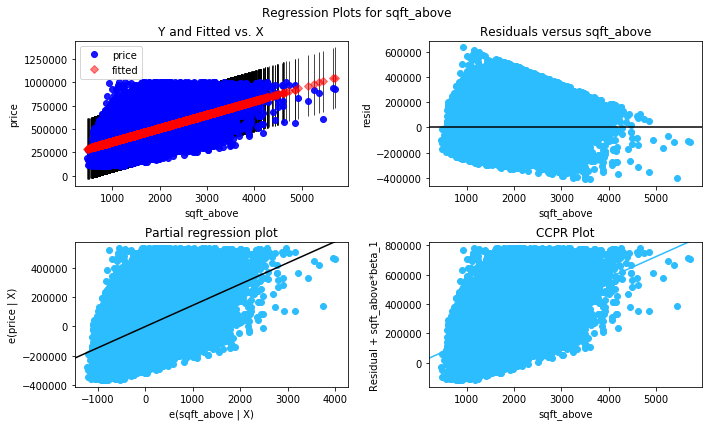

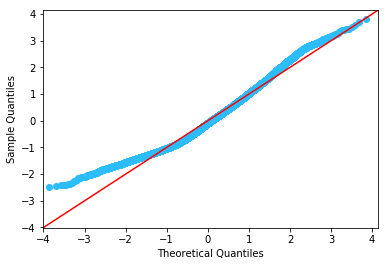

In [48]:
df_features = df.drop(["price"], axis=1)

for i in ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'grade', 'sqft_above']:
    f = 'price~{}'.format(i)
    
    print('King County House sales dataset - Regression Analysis / Diagnostics for formula: {}'.format(f))
    print('-------------------------------------------------------------------------------------')
        
    #build the model
    model = ols(formula=f, data=df).fit()
    
    #create the summary of the model
    print(model.summary())
    
    #create regression line and plot scatter
    i_extremes = [df[i].min(), df[i].max()]
    y_extremes = [model.params[0] + model.params[1] * j for j in i_extremes]
    
    plt.scatter(i, 'price', data = df, color = CB91_Blue)
    plt.xlabel(str(i))
    plt.ylabel('Sale Price')
    
    plt.plot(i_extremes, y_extremes, color = CB91_Violet)
    
    plt.show()
    
    #plot the regression plots
    fig = plt.figure(figsize=(10,6))
    fig = sm.graphics.plot_regress_exog(model, str(i), fig=fig)
    plt.show()
    
    #plot the qq plot
    residuals = model.resid
    fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, color = CB91_Blue)
    plt.show()

As we can see, none of these individual features make for particularly compelling single variable linear regressions. We can proceed with the multivariate regression.

# 3) Finalise features for the multi-variate regression

### Check for multicollinearity
Collinearity, cases where independent variables are highly correlated, are bad for the linear regression since we are unable to isolate causational relationships between variables.

We can identify collinearity by creating a heatmap with seaborn. We then delete any features displaying strong collinearity (including at least one category of each categorical feature). Firstly, create a dataframe removing the dependent variable.

In [49]:
df_features = df.drop(["price"], axis=1)

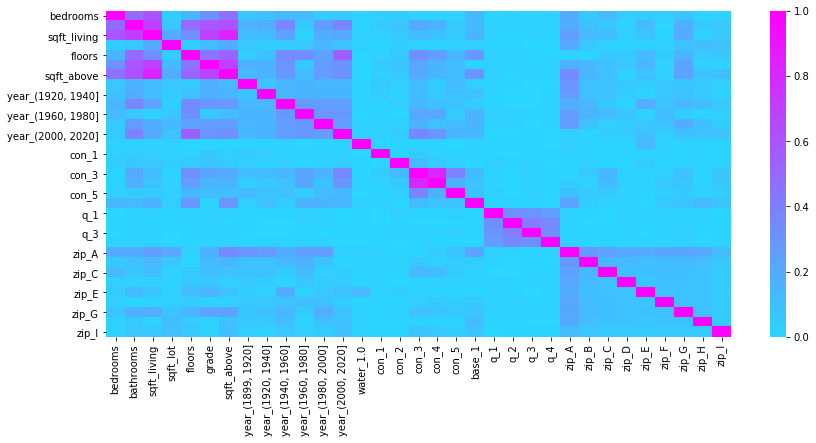

In [50]:
plt.figure(figsize = (14,6))
sns.heatmap(abs(df_features.corr()), center=0.4, cmap = "cool");

We should remove at least one of each remaining category (i.e. from year, condition, quarter, and zip group).

In [51]:
df.drop(["con_3","q_3","year_(2000, 2020]","zip_I"], axis=1, inplace = True)

We can now drop features that continue to demonstrate high levels of collinearity (above 0.6), though we should do this step-wise, since collinearity may change as we remove features.

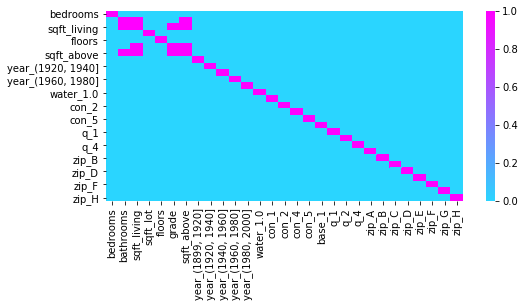

In [52]:
df_features = df.drop(["price"], axis=1)
plt.figure(figsize = (8,3.5))
sns.heatmap(abs(df_features.corr() > 0.6), center=0.4, cmap = "cool");

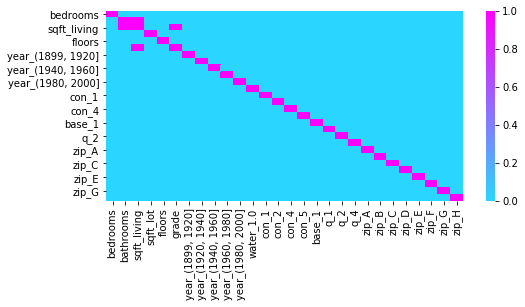

In [53]:
df.drop(["sqft_above"], axis=1, inplace = True)
df_features = df.drop(["price"], axis=1)
plt.figure(figsize = (8,3.5))
sns.heatmap(abs(df_features.corr() > 0.6), center=0.4, cmap = "cool");

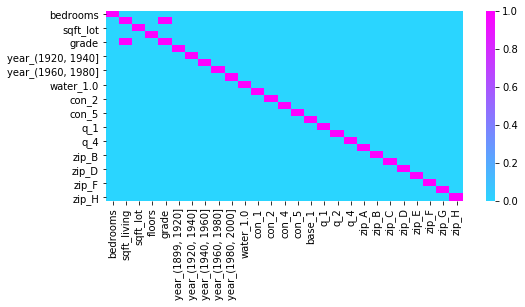

In [54]:
df.drop(["bathrooms"], axis=1, inplace = True)
df_features = df.drop(["price"], axis=1)
plt.figure(figsize = (8,3.5))
sns.heatmap(abs(df_features.corr() > 0.6), center=0.4, cmap = "cool");

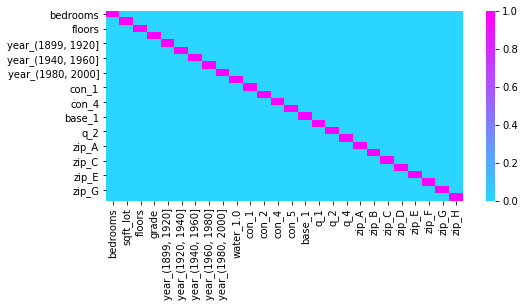

In [55]:
df.drop(["sqft_living"], axis=1, inplace = True)
df_features = df.drop(["price"], axis=1)
plt.figure(figsize = (8,3.5))
sns.heatmap(abs(df_features.corr() > 0.6), center=0.4, cmap = "cool");

We have thus removed all instances of high collinearity.

### Transform data where required
Investigate histograms of the non-categorical independent variables, and consider log-transformations to encourage normal distributions.

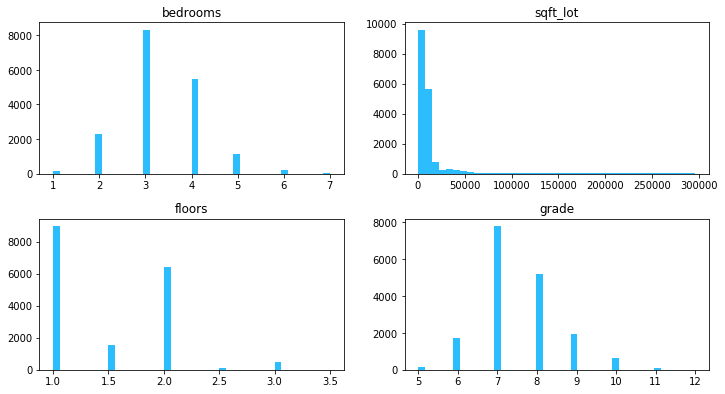

In [56]:
c = []
n = 2

for i in ['bedrooms','sqft_lot','floors','grade']:
    if df[i].dtype != 'object':
        c.append(i)
        
l = len(c)

fig, axes = plt.subplots(ncols = n, nrows = l // n + 1, figsize = (12,10))

fig.subplots_adjust(hspace=0.3)

for a in range(l):
    ax = axes[a//n][a%n]
    ax.hist(df[c[a]], bins = 40)
    ax.set_title(c[a])

spare = n * (l // n + 1) - l

for b in range(spare):
    fig.delaxes(axes[l // n][n - 1 - b])

There is scope to log transform variables concerning number of bedrooms, the property grade, and the sqft of the lot, in order to achieve a normal distribution.

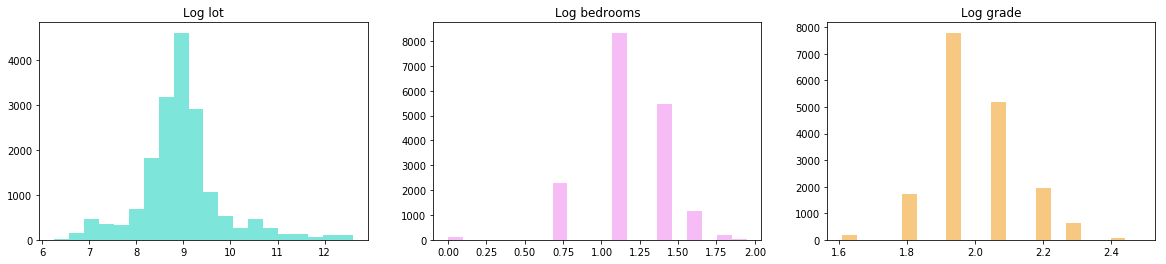

In [57]:
log_lot = np.log(df['sqft_lot'])
log_bed = np.log(df['bedrooms'])
log_grade = np.log(df['grade'])

fig = plt.figure(figsize = (20,4))

ax1 = fig.add_subplot(131)
ax1.hist(log_lot, color = CB91_Green, alpha = 0.7, bins = 20)
ax1.set_title('Log lot')

ax2 = fig.add_subplot(132)
ax2.hist(log_bed, color = CB91_Pink, alpha = 0.7, bins = 20)
ax2.set_title('Log bedrooms')

ax3 = fig.add_subplot(133)
ax3.hist(log_grade, color = CB91_Amber, alpha = 0.7, bins = 20)
ax3.set_title('Log grade')

plt.show()

Though the histograms are not perfectly normal, we see a much greater tendency towards a normal 'bell curve' than before. We can add our log-transformed features back to the dataframe, replacing their old versions.

In [58]:
df.drop(["sqft_lot","bedrooms","floors","grade"], axis=1, inplace = True)
df = pd.concat([df, log_bed, log_lot, log_grade], axis=1)

We now edit the column names, removing certain characters that scikit learn doesn't like.

In [59]:
df.columns = list(map(lambda x: x.replace('(','').replace(']','').replace('_1.0','side').replace(', ','_'),df.columns))

# 4) Conduct analysis

In [60]:
df_features = df.drop(["price"], axis=1)

### Select features
Use stepwise selection to decide which features to include in the model. This will ensure that we do not include any features with p-values of above 0.05.

In [61]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [62]:
df_features = df.drop(["price"], axis=1)

df_selected = stepwise_selection(df_features,df['price'])

/Users/Callum/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  grade                          with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  zip_F                          with p-value 0.0
Add  zip_D                          with p-value 7.93701e-267
Add  zip_H                          with p-value 0.0
Add  zip_E                          with p-value 1.07302e-198
Add  sqft_lot                       with p-value 1.1089e-174
Add  bedrooms                       with p-value 5.10332e-145
Add  year_1899_1920                 with p-value 3.39712e-124
Add  year_1920_1940                 with p-value 8.07067e-182
Add  year_1940_1960                 with p-value 9.62111e-68
Add  base_1                         with p-value 1.00495e-53
Add  waterside                      with p-value 7.89533e-51
Add  con_5                          with p-value 3.08656e-33
Add  con_4                          with p-value 8.23331e-20
Add  year_1960_1980                 with p-value 2.49003e-19
Add  year_1980_2000                 with p-value 1.

/Users/Callum/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  zip_B                          with p-value 7.84445e-13
Add  q_4                            with p-value 5.42218e-07
Add  con_2                          with p-value 0.000278828
Add  zip_A                          with p-value 0.000818336
Add  zip_G                          with p-value 5.4789e-18
Drop year_1940_1960                 with p-value 0.16721
Add  q_2                            with p-value 0.00266057
Add  q_1                            with p-value 1.90279e-05
Drop q_4                            with p-value 0.133406


Having selected our features stepwise, we can save down final dataframes of features, and the dependent variable.

In [63]:
X = df[sorted(df_selected)]
y = df['price']

### Create model
Use scikit learn to create the model using the selected features.

In [64]:
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

We can now use scikit learn's intercept_ and coef_ functions to see what our model looks like.

In [65]:
linreg.intercept_

-1650121.6217477089

In [66]:
coefficients = dict(zip(X,list(linreg.coef_)))
coefficients

{'base_1': 29252.375427747455,
 'bedrooms': 83766.82050870422,
 'con_2': -35528.31085484564,
 'con_4': 24766.09121015148,
 'con_5': 53317.91064605262,
 'grade': 854318.3316310783,
 'q_1': 12423.418065479309,
 'q_2': 11812.383535581128,
 'sqft_lot': 31234.329115173532,
 'waterside': 270635.4406188209,
 'year_1899_1920': 93013.93683601837,
 'year_1920_1940': 79781.07944541666,
 'year_1960_1980': -48899.98484720863,
 'year_1980_2000': -28907.587952578353,
 'zip_A': 51516.25003943929,
 'zip_B': 65576.72851136314,
 'zip_C': 74431.2971505616,
 'zip_D': -124510.21509782918,
 'zip_E': -87154.42909330239,
 'zip_F': -159891.5983414118,
 'zip_G': 50994.685325042665,
 'zip_H': -117246.44910310197}

Looking through these coefficients, we can see how the different attributes drive the value of a house.

* A basement is worth, on average, 29k
* A higher condition is associated with a higher value
* Being next to the water adds a huge amount of value - on average 270k
* The most valuable zip codes fall in areas B and C (i.e. Kirkland, Kenmore, Bothell, Redmond, Woodinville, Bellevue, Medina, Mercer Island, and Newcastle)
* The least valuable zip codes fall in area F (i.e. Federal Way, Auburn, Algona, Milton, Pacific)

We can reverse engineer the log transformations to see the relative price impact of extra units of bedrooms, sqft lot, and grade.

In [67]:
['{} Bedrooms: +${}'.format(i, round(coefficients['bedrooms'] * np.log(i), 0))
 for i in range(1,6)]

['1 Bedrooms: +$0.0',
 '2 Bedrooms: +$58063.0',
 '3 Bedrooms: +$92027.0',
 '4 Bedrooms: +$116125.0',
 '5 Bedrooms: +$134817.0']

In [68]:
['{} sqft lot: +${}'.format(i, round(coefficients['sqft_lot'] * np.log(i), 0))
 for i in np.linspace(10000, 50000, 5)]

['10000.0 sqft lot: +$287679.0',
 '20000.0 sqft lot: +$309329.0',
 '30000.0 sqft lot: +$321993.0',
 '40000.0 sqft lot: +$330979.0',
 '50000.0 sqft lot: +$337949.0']

In [69]:
['Grade {}: +${}'.format(i, round(coefficients['grade'] * np.log(i), 0))
 for i in range(5,13)]

['Grade 5: +$1374972.0',
 'Grade 6: +$1530733.0',
 'Grade 7: +$1662427.0',
 'Grade 8: +$1776505.0',
 'Grade 9: +$1877129.0',
 'Grade 10: +$1967141.0',
 'Grade 11: +$2048566.0',
 'Grade 12: +$2122901.0']

### Test Model

Use scikit learn to evaluate R^2, and adjusted R^2.

In [70]:
yhat = linreg.predict(X)

In [71]:
SS_residual = np.sum((y - yhat)**2)
SS_total = np.sum((y - np.mean(y))**2)

r_squared = 1 - (float(SS_residual)) / SS_total
adj_r_squared = 1 - (1 - r_squared)*(len(y) - 1) / (len(y) - X.shape[1] - 1)

In [72]:
r_squared

0.6711183085344893

In [73]:
adj_r_squared

0.6707052585138098

We can be confident that our r squared and adjusted r squared are very very similar.

We can therefore say that over two thirds of the dataset's variation from the mean can be explained by our model.

### Testing for over-fitting

Use scikit learn to conduct K-Fold Cross Validation.

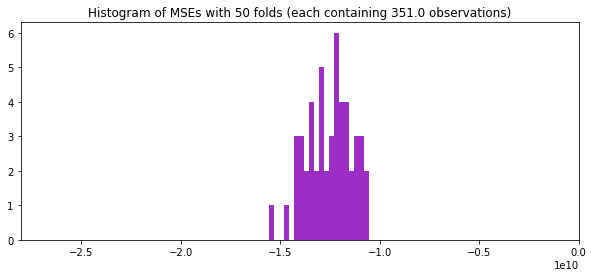

In [74]:
folds = 50
kfold_val = cross_val_score(linreg, X, y, cv = folds, scoring = "neg_mean_squared_error")

plt.figure(figsize = (10,4))
plt.hist(kfold_val, bins = 20, color = CB91_Purple);
plt.xlim(left = min(kfold_val)*1.8, right = 0);
plt.title('Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(df) / folds, 0)));

The above histogram suggests that even with 50 folds (each fold including 350 observations), the mean square errors fall in a relatively narrow range. This suggests that the model does not overly suffer from over-fitting.

# 5) Predicting property prices
We now have all the pieces we need to evaluate property prices, using the model.

We can write code, which takes the characteristics of a property as its input, and outputs an estimated price.

In [75]:
def price_calculator():
    
    '''Parameters:
           (): No parameters, but will get input from the user.
       Returns:
           Price (float): The property's estimated value, given by the model constructed above.'''
    
    price = linreg.intercept_
    
# Bedrooms
    beds = input("How many bedrooms does the property have? ")
    bed_value = coefficients['bedrooms'] * np.log(float(beds))
    price += bed_value
    
# Grade
    grade = input("What is the grade of the property (5-12)? ")
    grade_value = coefficients['grade'] * np.log(float(grade))
    price += grade_value
    
# Size of lot
    lot = input("How many sqft is the property lot? ")
    lot_value = coefficients['sqft_lot'] * np.log(float(lot))
    price += lot_value
    
# Location
    zipc = input("What is the property's zipcode? ")
    area = 'zip_{}'.format(zipcode(int(zipc)))
    area_value = max([coefficients[area], 0])
    price += area_value
    
# Build year
    year = int(input("What year was the property built in? "))
    if year < 1920:
        year = 'year_1899_1920'
    elif year < 1940:
        year = 'year_1920_1940'
    elif year < 1960:
        year = 'year_1940_1960'
    elif year < 1980:
        year = 'year_1960_1980'
    elif year < 2000:
        year = 'year_1980_2000'
    else: year = 0
    
    price += coefficients[year]
    
# Property condition
    con = int(input("What is the property condition (2-5)? "))
    if con == 3:
        con_value = 0
    else:
        con = 'con_{}'.format(con)
        con_value = coefficients[con]
        
    price += con_value
    
# Transaction quarter
    tq = int(input("Which quarter was/is the sale transaction in (1-4)? "))
    if tq > 2:
        tq_value = 0
    else:
        tq = 'q_{}'.format(tq)
        tq_value = coefficients[tq]
    
    price += tq_value

# Waterside
    waterside = input("Is the property waterside (y/n)? ")
    if waterside == 'y':
        w_value = coefficients['waterside']
    else:
        w_value = 0
               
    price += w_value

# Basement
    basement = input("Does the property have a basement (y/n)? ")
    if basement == 'y':
        b_value = coefficients['base_1']
    else:
        b_value = 0
               
    price += b_value
               
    return 'The property is worth ${}'.format(round(price, 0))

In [76]:
# price_calculator()